In [1]:
import gym
import gym.spaces
import numpy as np
import argparse
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

/Users/laurenelisegardiner/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# hit 'em with those hyperparams

In [16]:
num_episodes = 1000
max_time = 200
learning_rate = 0.01
discount_rate = 0.99
epochs = 500
state_size = 4
action_size = 2
hidden_state_size = 16

# calculate rewards at each state if it were the start

In [3]:
def expected_rewards(episode_rewards, gamma, normalize=True):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    if normalize:
        mean = np.mean(discounted_episode_rewards)
        std = np.std(discounted_episode_rewards)
        discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards.tolist()

# handle image input

In [4]:
def preprocess(image):
  #prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array
  image = image[35:195] # crop
  image = image[::2,::2,0] # downsample by factor of 2
  image[image == 144] = 0 # erase background (background type 1)
  image[image == 109] = 0 # erase background (background type 2)
  image[image != 0] = 1 # everything else (paddles, ball) just set to 1
  return np.reshape(image.astype(np.float).ravel(), [80,80])

# design network

In [5]:
class PolicyGradient():
    def __init__(self, learning_rate=0.001, state_size=6400, action_size=2, hidden_state_size=16, name="PolicyGradient"):
        with tf.name_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name="actions")
            self.expected_episode_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_episode_rewards")
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_state_size, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, action_size, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, action_size,weights_initializer=tf.contrib.layers.xavier_initializer(), activation_fn=None)
        with tf.name_scope("softmax"):
            self.softmax = tf.nn.softmax(self.fc3)
        with tf.name_scope("loss"):
            self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.actions_, logits = self.fc3)
            self.loss = tf.reduce_mean(self.cross_entropy * self.expected_episode_rewards_)
        with tf.name_scope("train"):
            self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

# play

In [8]:
# Load game
env = gym.make("Pong-v0")
# Initialize the game
state = env.reset()

In [9]:
tf.reset_default_graph()
network = PolicyGradient(name='network', learning_rate=learning_rate)

In [ ]:
# saver = tf.train.Saver()
avg_epoch_rewards = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        epoch_states, epoch_actions, epoch_rewards = [],[],[]
        total_episode_rewards = []
        for episode in range(num_episodes):
            # Initialize episode states, actions, and rewards
            episode_states, episode_actions, episode_rewards = [],[],[]
            # Initialize the game for the episode
            state = env.reset()
            
            while True:
                state = preprocess(state).reshape(1, 6400)
                feed = {network.inputs_: state}
                action_dist = sess.run(network.softmax, feed_dict=feed)
                
                # Add 2 to either 0 or 1 to make the options 2 or 3 (right or left)
                action = np.random.choice(range(action_dist.shape[1]), p=action_dist.flatten()) + 2
                next_state, reward, done, _ = env.step(action)
                
                # Create one hot encoding for action
                one_hot_action_ = np.zeros(action_size)
                one_hot_action_[action - 2] = 1


                # Store the states, reward, and action
                episode_states.append(state)
                episode_rewards.append(reward)
                episode_actions.append(one_hot_action_)
            
                
                state = next_state
                
                if done:
                    # Calculate the cummulative reward
                    expected_episode_rewards = expected_rewards(episode_rewards, discount_rate)
                    
                    total_episode_reward = sum(episode_rewards)
                    total_episode_rewards.append(total_episode_reward)
                    
                    # Epoch updates
                    epoch_states.append(np.vstack(episode_states))
                    epoch_actions.append(np.vstack(episode_actions))
                    epoch_rewards += expected_episode_rewards
                    
                    
                    break
                    
        loss_, _ = sess.run([network.loss, network.train], feed_dict={network.inputs_: np.vstack(epoch_states),
                                                                 network.actions_: np.vstack(epoch_actions),
                                                                 network.expected_episode_rewards_: epoch_rewards
                                                                })
        avg_epoch_reward = np.mean(total_episode_rewards)
        avg_epoch_rewards.append(avg_epoch_reward)
        print("Epoch: {0}\tAvg Reward: {1}".format(epoch, avg_epoch_reward))

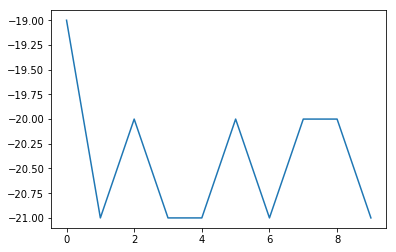

In [15]:
plt.plot(avg_epoch_rewards)